# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from GMHI import GMHI

# Set constants

In [2]:
# set colors
healthy_color = "steelblue"
nonhealthy_color = 'orange'

# set figure details
figsize = (10, 10)
dpi = 200

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

filename = "coefficients.svg"

# Load coefficients

In [3]:
gmhi2 = load(os.path.join(config.MODEL_DIR, "gmhi2_model.joblib"))
gmhi2

LogisticRegression(C=0.03, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [4]:
coefficients = pd.DataFrame(gmhi2.coef_.flatten(), index=gmhi2.feature_names_in_, columns=["Coefficient"])
coefficients

,Coefficient
k__Archaea,0.0
k__Archaea|p__Euryarchaeota,0.0
k__Archaea|p__Euryarchaeota|c__Methanobacteria,0.0
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,0.0
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,0.0
...,...
k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Pepper_mild_mottle_virus,0.0
k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Tobacco_mild_green_mosaic_virus,0.0
k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Deep_sea_thermophilic_phage_D6E,0.0
k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Loktanella_phage_pCB2051_A,0.0


# Rank order coefficients and plot

In [5]:
sorted_coefficients = coefficients.sort_values("Coefficient", ascending=False)
sorted_coefficients

,Coefficient
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ruminis,0.593211
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Romboutsia|s__Romboutsia_ilealis,0.460966
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_catenulatum,0.357945
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_167,0.243267
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_bicirculans,0.240001
...,...
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_pneumosintes,-0.418924
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_180,-0.463521
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_salivarius,-0.465074
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium,-0.559941


In [6]:
num_pos = (sorted_coefficients > 0).sum().sum()
num_neg = (sorted_coefficients < 0).sum().sum()
num_zero = (sorted_coefficients == 0).sum().sum()
num_coef = sorted_coefficients.shape[0]
buffer = 10
num_pos, num_neg, num_zero, num_coef

(59, 50, 3091, 3200)

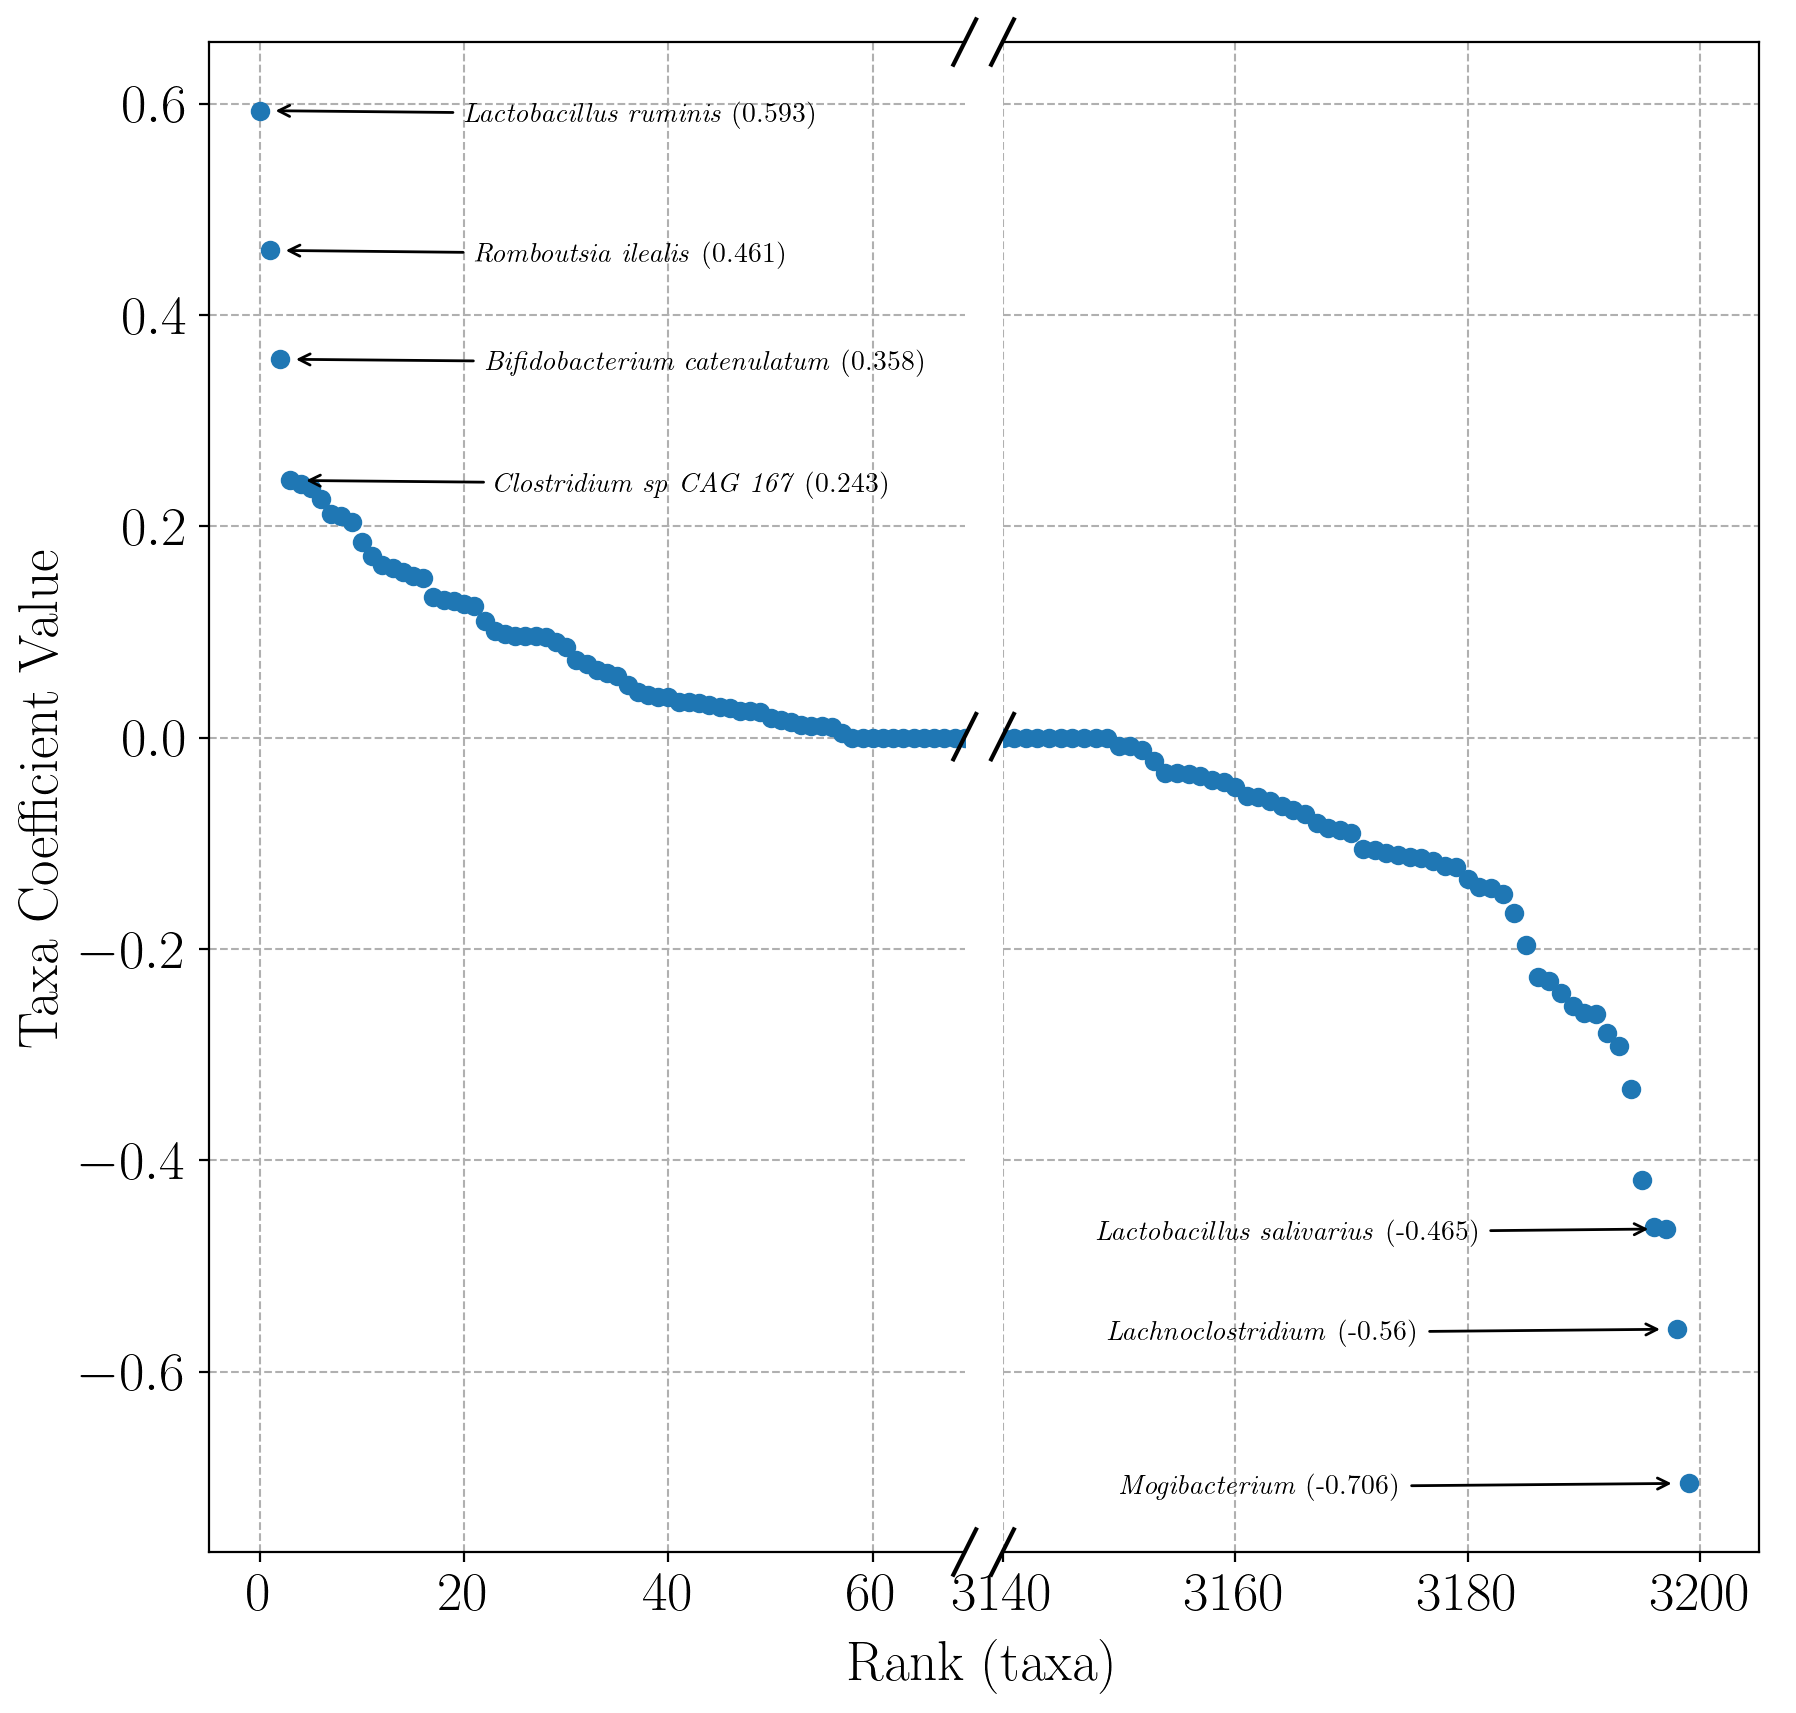

In [14]:
fig, (ax, ax2) = plt.subplots(1,2, sharey=True, facecolor='w', figsize=figsize, dpi=dpi)

axes = [ax, ax2]
for i, a in enumerate(axes):
    a.set_axisbelow(True)
    if i == 0:
        a.set_ylabel("Taxa Coefficient Value", fontsize=20)
    a.tick_params(axis="both", labelsize=20)
    a.scatter(np.arange(sorted_coefficients.shape[0]), sorted_coefficients)
    a.grid(linestyle = '--', linewidth = 0.75)
ax.set_xlim(-5, num_pos + buffer)
ax2.set_xlim(num_coef - num_neg - buffer, num_coef + 5)

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # bottom-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (0.54 - d, 0.54 + d), **kwargs)  # middle-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (-d, +d), **kwargs)        # bottom-right diagonal
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # top-right diagonal
ax2.plot((-d, +d), (0.54 - d, 0.54 + d), **kwargs)  # middle-right diagonal

fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Rank (taxa)", fontsize=20, labelpad=15)

fig.subplots_adjust(wspace=0.05)

# annotate top four coeff (pos and neg)
num_top = 4
for i in range(num_top):
    x, y = i, float(sorted_coefficients.iloc[i])
    taxa = sorted_coefficients.index[i].split("__")[-1].replace("_", " ")
    ax.annotate(r"\textit{" + taxa + '}' + f" ({round(y, 3)})", xy=(x + 1, y), xytext=(x + 20, y - 0.01),
                arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
                fontsize=10
    )
    
for i in range(num_top - 1):
    idx = -(1 + i)
    x, y = i, float(sorted_coefficients.iloc[idx])
    x = num_coef - x
    taxa = sorted_coefficients.index[idx].split("__")[-1].replace("_", " ")
    ax2.annotate(r"\textit{" + taxa + '}' + f" ({round(y, 3)})", xy=(x - 2, y), xytext=(x - 50, y - 0.01),
                arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
                fontsize=10
    )

plt.savefig(os.path.join(config.FIGURE_DIR, filename))

In [11]:
nonzero = sorted_coefficients[(sorted_coefficients != 0).values]
nonzero

,Coefficient
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ruminis,0.593211
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Romboutsia|s__Romboutsia_ilealis,0.460966
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_catenulatum,0.357945
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_167,0.243267
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_bicirculans,0.240001
...,...
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_pneumosintes,-0.418924
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_180,-0.463521
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_salivarius,-0.465074
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium,-0.559941


In [12]:
np.unique([tax.split("|")[-1].split("__")[0] for tax in nonzero.index], return_counts=True)

(array(['c', 'f', 'g', 'o', 's'], dtype='<U1'), array([ 1,  7, 19,  3, 79]))